In [23]:
# imports

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize



## Cleaning / EDA

* import the personal finance dataset

In [24]:
dfpf = pd.read_csv('../data/personal_finance.csv', index_col = 0)
dfpf.head()

,subreddit,selftext,title,created_utc
0,personalfinance,For years I put money into a deferred compensa...,Percentage of paycheck into Deferred Comp plan...,1673558530
1,personalfinance,So I’m 19 and currently in university And Ive ...,19yrs old First Car (you know the drill),1673557919
2,personalfinance,The other day I was turning right on a green i...,"Other driver ran into me, but I don't have ins...",1673557799
3,personalfinance,[removed],Need help with a parent who’s reluctant to beg...,1673557711
4,personalfinance,[removed],How do I buy a house? How do I qualify? What’s...,1673557611


In [25]:
dfpf.isnull().sum()

subreddit       0
selftext       22
title           0
created_utc     0
dtype: int64

* very small percentage of null values in the personal finance dataset selftext which does not comprise much of the dataset. Going to drop these values. 

In [26]:
dfpf.dropna(inplace = True)
dfpf.isnull().sum()

subreddit      0
selftext       0
title          0
created_utc    0
dtype: int64

In [27]:
dfpf.shape

(2978, 4)

In [28]:
dfpf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2978 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    2978 non-null   object
 1   selftext     2978 non-null   object
 2   title        2978 non-null   object
 3   created_utc  2978 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 116.3+ KB


In [29]:
dfpf['title'].value_counts()

Father left house in trust, but with stipulation wife can remain in house. Advice needed.    3
how much should i have in 401k at 25 years old?                                              2
35[F4M] Feeling lonely looking for someone to talk to ❤️ ❤️ US only 👌                        2
contributing to a 529 college savings plan through work or personal?                         2
Which house for RENT should I choose?                                                        2
                                                                                            ..
confused - EIC tax credit                                                                    1
Edward Jones Required Annual Review                                                          1
Should I resign now?                                                                         1
How much to save a month?                                                                    1
Retirement planning template for dual earners, dif

In [30]:
dfpf.columns

Index(['subreddit', 'selftext', 'title', 'created_utc'], dtype='object')

### financial independence dataframe

* import financial independence dataset

In [31]:
dffi = pd.read_csv('../data/financial_independence.csv', index_col = 0)
dffi.head()

,subreddit,selftext,title,created_utc
0,financialindependence,I know being a single 29M at 100k is not such ...,29M graduated in 2019 and I am 1k away from ne...,1673557670
1,financialindependence,[removed],Investing for the Future Vs Enjoying Life Now,1673553070
2,financialindependence,The other day I made a [similar post](https://...,Preparing to RE in event of terminal diagnosis,1673547665
3,financialindependence,[removed],I want some tips to start my journey to FI whi...,1673547294
4,financialindependence,Longtime lurker here. I don't know if people l...,Journey to the first $100k,1673544231


In [32]:
dffi.isnull().sum()

subreddit      0
selftext       0
title          0
created_utc    0
dtype: int64

In [33]:
dffi.shape

(1440, 4)

* joining the datasets together for further cleaning, eda, and preprocessing

In [34]:
df = pd.concat([dfpf, dffi], axis = 0)
df.head()

,subreddit,selftext,title,created_utc
0,personalfinance,For years I put money into a deferred compensa...,Percentage of paycheck into Deferred Comp plan...,1673558530
1,personalfinance,So I’m 19 and currently in university And Ive ...,19yrs old First Car (you know the drill),1673557919
2,personalfinance,The other day I was turning right on a green i...,"Other driver ran into me, but I don't have ins...",1673557799
3,personalfinance,[removed],Need help with a parent who’s reluctant to beg...,1673557711
4,personalfinance,[removed],How do I buy a house? How do I qualify? What’s...,1673557611


In [35]:
df.shape

(4418, 4)

In [36]:
print(df)

                  subreddit  \
0           personalfinance   
1           personalfinance   
2           personalfinance   
3           personalfinance   
4           personalfinance   
...                     ...   
1435  financialindependence   
1436  financialindependence   
1437  financialindependence   
1438  financialindependence   
1439  financialindependence   

                                               selftext  \
0     For years I put money into a deferred compensa...   
1     So I’m 19 and currently in university And Ive ...   
2     The other day I was turning right on a green i...   
3                                             [removed]   
4                                             [removed]   
...                                                 ...   
1435                                          [removed]   
1436                                          [removed]   
1437                                          [removed]   
1438                                 

* evaluating the balance of the classes

In [37]:
df['subreddit'].value_counts(normalize = True)

personalfinance          0.674061
financialindependence    0.325939
Name: subreddit, dtype: float64

* immediately notice the classes are imbalanced, 
baseline accuracy for model will be correctly predicting 67% personal finance

* binarizing the target column

In [38]:
df['subreddit'] = df['subreddit'].map({'personalfinance': 1, 'financialindependence': 0})

In [39]:
df['subreddit'].value_counts(normalize = True)

1    0.674061
0    0.325939
Name: subreddit, dtype: float64

* personal finance = 1 | financial independence = 0

In [40]:
print(df)

      subreddit                                           selftext  \
0             1  For years I put money into a deferred compensa...   
1             1  So I’m 19 and currently in university And Ive ...   
2             1  The other day I was turning right on a green i...   
3             1                                          [removed]   
4             1                                          [removed]   
...         ...                                                ...   
1435          0                                          [removed]   
1436          0                                          [removed]   
1437          0                                          [removed]   
1438          0                                          [removed]   
1439          0                                          [removed]   

                                                  title  created_utc  
0     Percentage of paycheck into Deferred Comp plan...   1673558530  
1              19

In [41]:
df.columns

Index(['subreddit', 'selftext', 'title', 'created_utc'], dtype='object')

* I no longer need the UTC column, drop the unneeded column

In [42]:
df.drop(columns = ['created_utc'], inplace = True)
df.head()

,subreddit,selftext,title
0,1,For years I put money into a deferred compensa...,Percentage of paycheck into Deferred Comp plan...
1,1,So I’m 19 and currently in university And Ive ...,19yrs old First Car (you know the drill)
2,1,The other day I was turning right on a green i...,"Other driver ran into me, but I don't have ins..."
3,1,[removed],Need help with a parent who’s reluctant to beg...
4,1,[removed],How do I buy a house? How do I qualify? What’s...


### Vectorizing / Tokenizing for preprocessing 

In [43]:
X = df['title']
y = df['subreddit']

In [44]:
cvec = CountVectorizer()

In [45]:
cvec.fit(X)

CountVectorizer()

In [46]:
xdf = cvec.transform(X)
xdf

<4418x4593 sparse matrix of type '<class 'numpy.int64'>'
	with 38123 stored elements in Compressed Sparse Row format>

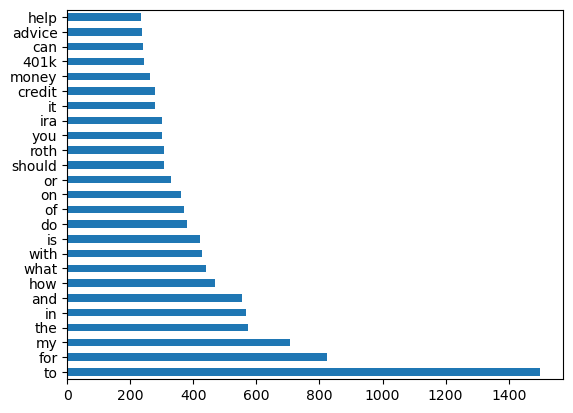

In [47]:
xdf2 = pd.DataFrame(xdf.todense(),
                   columns = cvec.get_feature_names_out())

xdf2.sum().sort_values(ascending = False).head(25).plot(kind = 'barh');

* lots of stop words! Will make sure to monitor how that impacts model performance

In [48]:
df.to_csv('combined_data.csv')

In [49]:
from nltk.stem import WordNetLemmatizer


In [50]:
df.isnull().sum()

subreddit    0
selftext     0
title        0
dtype: int64

* practicing with the tokenizer
* https://practicaldatascience.co.uk/machine-learning/how-to-perform-tokenization-in-nlp-with-nltk-and-python

in order to ulitize tokenizer....
1. cast to a string (drop nan values if necessary)
2. write a function to tokenize
3. tokenize data then add tokenized column

In [51]:
df['title'] = df['title'].astype(str)
df.head()

,subreddit,selftext,title
0,1,For years I put money into a deferred compensa...,Percentage of paycheck into Deferred Comp plan...
1,1,So I’m 19 and currently in university And Ive ...,19yrs old First Car (you know the drill)
2,1,The other day I was turning right on a green i...,"Other driver ran into me, but I don't have ins..."
3,1,[removed],Need help with a parent who’s reluctant to beg...
4,1,[removed],How do I buy a house? How do I qualify? What’s...


In [52]:
df['title'] = df['title'].str.lower()

In [53]:
def tokenize(column):
    tokens = word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

df['tokenized'] = df.apply(lambda x: tokenize(x['title']), axis = 1)
df.head()

,subreddit,selftext,title,tokenized
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com..."
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]"
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav..."
3,1,[removed],need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan..."
4,1,[removed],how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif..."


In [54]:
print(df['tokenized'])

0       [percentage, of, paycheck, into, deferred, com...
1                [old, first, car, you, know, the, drill]
2       [other, driver, ran, into, me, but, i, do, hav...
3       [need, help, with, a, parent, who, s, reluctan...
4       [how, do, i, buy, a, house, how, do, i, qualif...
                              ...                        
1435    [should, i, start, paying, down, debt, or, kee...
1436                    [in, need, of, financial, advice]
1437                             [stop, putting, into, b]
1438    [como, financiar, um, carro, sem, juros, abusi...
1439    [what, the, best, way, to, start, finding, out...
Name: tokenized, Length: 4418, dtype: object


In [55]:
df['title_length'] = df['title'].apply(len)

In [56]:
df.head()

,subreddit,selftext,title,tokenized,title_length
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com...",62
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]",40
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav...",53
3,1,[removed],need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan...",76
4,1,[removed],how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif...",59


* personal finance = 1 | financial independence = 0


In [57]:
df.to_csv('tokenized_dataframe.csv')

* new column to add title word count

In [58]:
df['word_count'] = df['title'].apply(lambda x: len(x.split()))
df.tail()

,subreddit,selftext,title,tokenized,title_length,word_count
1435,0,[removed],should i start paying down debt or keep invest...,"[should, i, start, paying, down, debt, or, kee...",50,9
1436,0,[removed],18yo in need of financial advice.,"[in, need, of, financial, advice]",33,6
1437,0,[removed],stop putting into 403 b,"[stop, putting, into, b]",23,5
1438,0,[removed],como financiar um carro sem juros abusivos?,"[como, financiar, um, carro, sem, juros, abusi...",43,7
1439,0,[removed],what the best way to start finding out about f...,"[what, the, best, way, to, start, finding, out...",140,27


In [59]:
df.head(100)

,subreddit,selftext,title,tokenized,title_length,word_count
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com...",62,9
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]",40,8
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav...",53,10
3,1,[removed],need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan...",76,14
4,1,[removed],how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif...",59,13
...,...,...,...,...,...,...
95,1,"Hi all, new to this sub. So, I woke up this mo...","23 yr old, nyc. 10k debt","[yr, old, nyc, debt]",24,6
96,1,Let's say I had my basic necessities taken car...,what are any money growing techniques that i c...,"[what, are, any, money, growing, techniques, t...",95,20
97,1,[removed],"around $10,000 in total debt. 23 yr old male. nyc","[around, in, total, debt, yr, old, male, nyc]",49,10
98,1,I have little savings in digital bank (cimb) w...,coop vs. digital banks,"[coop, digital, banks]",22,4


In [60]:
df.describe()

,subreddit,title_length,word_count
count,4418.000000,4418.000000,4418.000000
mean,0.674061,52.564735,9.478950
std,0.468778,30.272283,5.788721
min,0.000000,3.000000,1.000000
25%,0.000000,31.250000,5.000000
50%,1.000000,46.000000,8.000000
75%,1.000000,66.000000,12.000000
max,1.000000,299.000000,55.000000


* printing the length of the subset of the dataframe, based on two conditions, i.e. printing the number of rows in the subset

### Adding SelfText as a Feature

In [61]:
print(len(df[(df['subreddit'] == 1) & (df['selftext'] == '[removed]')]))

print(len(df[(df['subreddit'] == 0) & (df['selftext'] == '[removed]')]))



518
689


In [62]:
df.isnull().sum()

subreddit       0
selftext        0
title           0
tokenized       0
title_length    0
word_count      0
dtype: int64

* due to poor overall performance of most initial modeling, will see if adding selftext as a feature will help the predictive nature of the models. 
* many of the financial independence rows have no values inside. Received a great suggestion from Jeff to try adding the selftext and title columns together inhopes that more data will help the models. 
* Will convert the ['removed'] values to empty strings to then add to the title column

In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subreddit,4418.0,0.674061,0.468778,0.0,0.0,1.0,1.0,1.0
title_selftext_word_count,4418.0,115.158669,141.852067,1.0,16.0,82.0,153.0,2110.0
title_selftext_length,4418.0,630.043006,786.951645,4.0,88.0,450.0,835.0,12446.0


In [63]:
df['selftext'].replace('[removed]', ' ', inplace = True)
df['title_selftext'] = df['title'] + df['selftext']
df.head()

,subreddit,selftext,title,tokenized,title_length,word_count,title_selftext
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com...",62,9,percentage of paycheck into deferred comp plan...
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]",40,8,19yrs old first car (you know the drill)So I’m...
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav...",53,10,"other driver ran into me, but i don't have ins..."
3,1,,need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan...",76,14,need help with a parent who’s reluctant to beg...
4,1,,how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif...",59,13,how do i buy a house? how do i qualify? what’s...


In [64]:
df['title_selftext_word_count'] = df['title_selftext'].apply(lambda x: len(x.split()))
df.head()

,subreddit,selftext,title,tokenized,title_length,word_count,title_selftext,title_selftext_word_count
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com...",62,9,percentage of paycheck into deferred comp plan...,121
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]",40,8,19yrs old first car (you know the drill)So I’m...,94
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav...",53,10,"other driver ran into me, but i don't have ins...",157
3,1,,need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan...",76,14,need help with a parent who’s reluctant to beg...,14
4,1,,how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif...",59,13,how do i buy a house? how do i qualify? what’s...,13


In [65]:
df['title_selftext_length'] = df['title_selftext'].apply(len)
df.head()

,subreddit,selftext,title,tokenized,title_length,word_count,title_selftext,title_selftext_word_count,title_selftext_length
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com...",62,9,percentage of paycheck into deferred comp plan...,121,682
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]",40,8,19yrs old first car (you know the drill)So I’m...,94,444
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav...",53,10,"other driver ran into me, but i don't have ins...",157,801
3,1,,need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan...",76,14,need help with a parent who’s reluctant to beg...,14,77
4,1,,how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif...",59,13,how do i buy a house? how do i qualify? what’s...,13,60


In [66]:
df.drop(columns = ['title_length', 'word_count'], inplace = True)
df.head()

,subreddit,selftext,title,tokenized,title_selftext,title_selftext_word_count,title_selftext_length
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com...",percentage of paycheck into deferred comp plan...,121,682
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]",19yrs old first car (you know the drill)So I’m...,94,444
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav...","other driver ran into me, but i don't have ins...",157,801
3,1,,need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan...",need help with a parent who’s reluctant to beg...,14,77
4,1,,how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif...",how do i buy a house? how do i qualify? what’s...,13,60


In [87]:
df.dtypes

subreddit                     int64
selftext                     object
title                        object
tokenized                    object
title_selftext               object
title_selftext_word_count     int64
title_selftext_length         int64
dtype: object

In [67]:
df.to_csv('revised_with_selftext.csv')

In [93]:
per_fin = df[df['subreddit'] == 1]
fin_ind = df[df['subreddit'] == 0]

In [94]:
per_fin.head()

,subreddit,selftext,title,tokenized,title_selftext,title_selftext_word_count,title_selftext_length
0,1,For years I put money into a deferred compensa...,percentage of paycheck into deferred comp plan...,"[percentage, of, paycheck, into, deferred, com...",percentage of paycheck into deferred comp plan...,121,682
1,1,So I’m 19 and currently in university And Ive ...,19yrs old first car (you know the drill),"[old, first, car, you, know, the, drill]",19yrs old first car (you know the drill)So I’m...,94,444
2,1,The other day I was turning right on a green i...,"other driver ran into me, but i don't have ins...","[other, driver, ran, into, me, but, i, do, hav...","other driver ran into me, but i don't have ins...",157,801
3,1,,need help with a parent who’s reluctant to beg...,"[need, help, with, a, parent, who, s, reluctan...",need help with a parent who’s reluctant to beg...,14,77
4,1,,how do i buy a house? how do i qualify? what’s...,"[how, do, i, buy, a, house, how, do, i, qualif...",how do i buy a house? how do i qualify? what’s...,13,60


top bigrams

In [101]:
pd.Series([' '.join(i) for i in per_fin['tokenized']])

0       percentage of paycheck into deferred comp plan...
1                        old first car you know the drill
2        other driver ran into me but i do have insurance
3       need help with a parent who s reluctant to beg...
4       how do i buy a house how do i qualify what s t...
                              ...                        
2973                        withdrawing from a pension at
2974                i bond in gift box recipient deceased
2975                            lump sum roth ira payment
2976    looking for a specific loan calculator would l...
2977    retirement planning template for dual earners ...
Length: 2978, dtype: object

In [104]:
pd.Series([' '.join(i) for i in fin_ind['tokenized']])

0            graduated in and i am away from net worth of
1           investing for the future vs enjoying life now
2          preparing to re in event of terminal diagnosis
3       i want some tips to start my journey to fi whi...
4                                    journey to the first
                              ...                        
1435    should i start paying down debt or keep investing
1436                          in need of financial advice
1437                                  stop putting into b
1438           como financiar um carro sem juros abusivos
1439    what the best way to start finding out about f...
Length: 1440, dtype: object

In [106]:
cv = CountVectorizer(stop_words = 'english', ngram_range = (2,2))

per_fin_vec = cv.fit_transform(pd.Series([' '.join(i) for i in per_fin['tokenized']]))
per_fin_vec_df = pd.DataFrame(per_fin_vec.todense(), columns = cv.get_feature_names_out())

fin_vec = cv.fit_transform(pd.Series([' '.join(i) for i in fin_ind['tokenized']]))
fin_vec_df = pd.DataFrame(fin_vec.todense(), columns = cv.get_feature_names_out())

In [108]:
per_fin_vec_df

,aaa auto,abandon rental,abbassare la,able access,able backdoor,able downgrade,able fund,able withdraw,abroad wise,abroad years,...,youtube uk,yr mortgage,yr old,yrs old,yt channel,zaiba arabi,zelle receive,zelle users,zero balance,zero debt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
fin_vec_df

,able generate,able max,able pay,able savings,abusive father,acc help,accelerate wealth,accelerator framework,accepted american,access marketing,...,yr wants,zero climate,zero wait,zksync airdrop,zksync crypto,zksync funds,zksync gift,zksync gifting,zksync new,zksync present
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


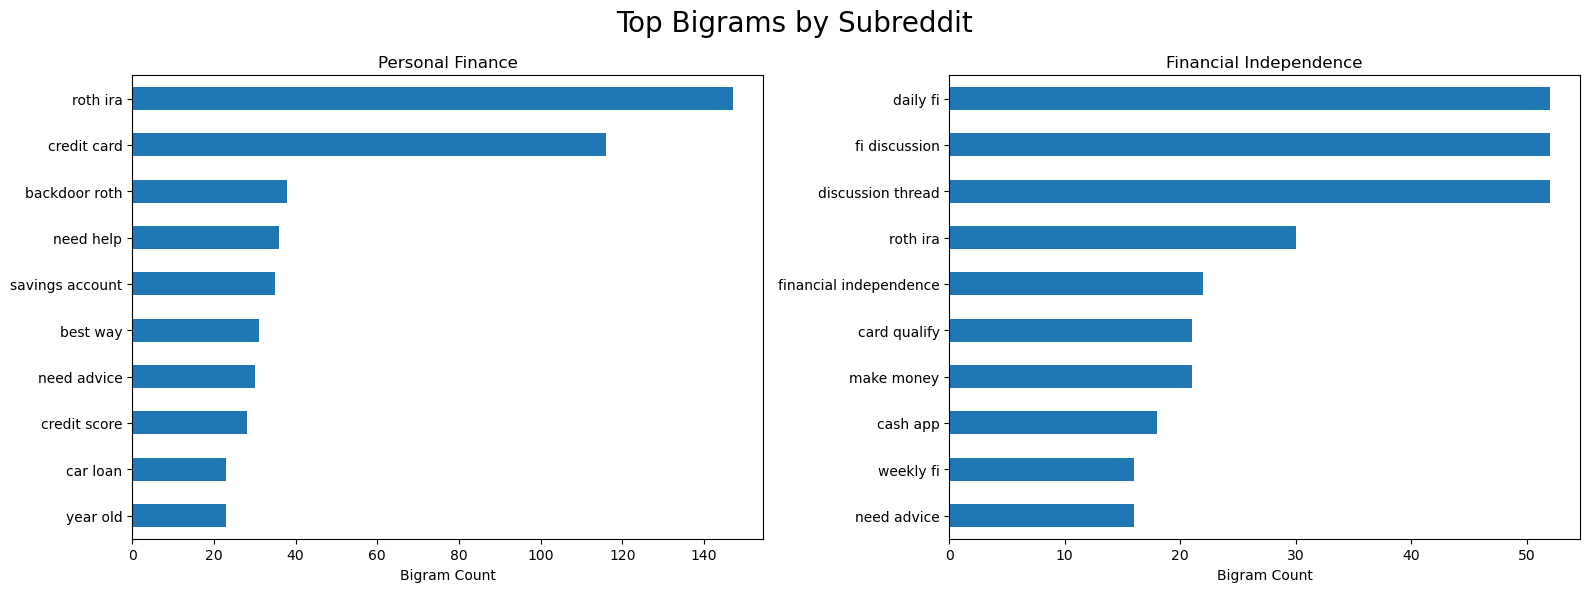

In [124]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
per_fin_vec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0])
fin_vec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis();

ax[0].set(xlabel='Bigram Count', title='Personal Finance')
ax[1].set(xlabel='Bigram Count', title='Financial Independence')

fig.suptitle('Top Bigrams by Subreddit', fontsize=20);

plt.tight_layout()
plt.savefig('../images/top bigrams by subreddit.jpg')

* seems to be some obvious overlap in word usage. discussion thread sticks out and doesn't seem relevant but may help model differentiate

In [110]:
import seaborn as sns


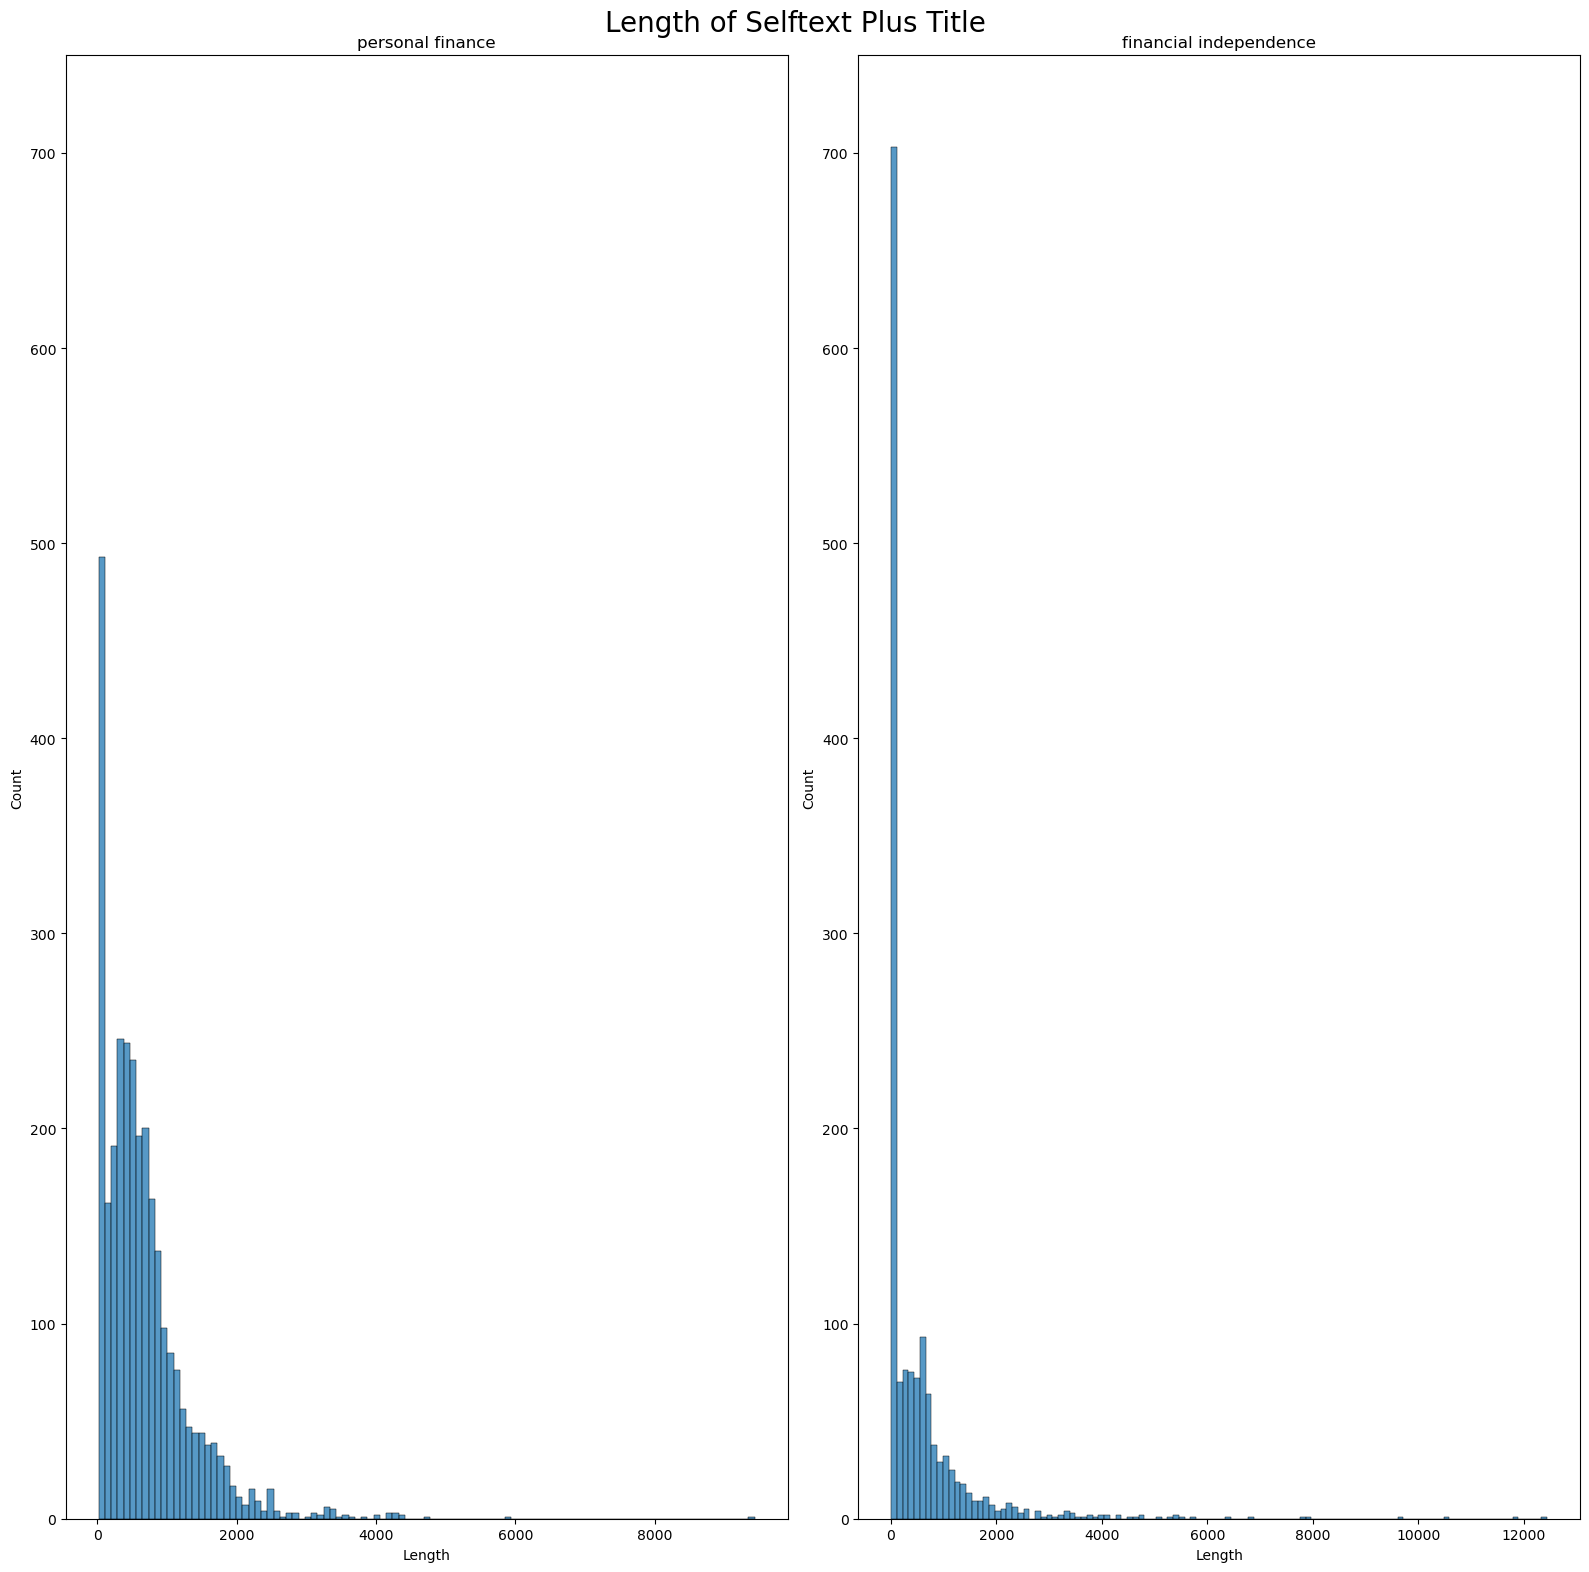

In [122]:
fig, ax = plt.subplots(1,2, figsize=(16,16))
sns.histplot(per_fin['title_selftext_length'], ax=ax[0])
sns.histplot(fin_ind['title_selftext_length'], ax=ax[1])


ax[0].set(xlabel='Length', title='personal finance', ylim = [0, 750])
ax[1].set(xlabel='Length', title='financial independence', ylim = [0, 750]) 


fig.suptitle('Length of Selftext Plus Title', fontsize=20);

plt.tight_layout()
plt.savefig('../images/Length of SelfText Plus Title.jpg')